# N-step Q-learning

In this part, we implement the N-step variant of the Q-learning algorithm, using a replay buffer as we did for studying the off-policy property of Q-learning.

Using the N-Steps return accelerates the learning process by updating the Q values of $N-1$ states at a time, by recording together succesive states visited by the agent.

In this lab, we focus on updating the states visited by the agent when following its policy until he reached its current state.

### Create a class NStepSample

An N-step sample contains N samples, corresponding to N consecutive steps of an agent.

In the cell below, import the Sample class from the [on_off_policy.ipynb](on_off_policy.ipynb) notebook and create a class to store an N-step sample.

In [3]:
"define NSTepSample class here"
from ipynb.fs.defs.on_off_policy import Sample

class NSample():
    
    def __init__(self, samples):
        self.buffer = [sample for sample in samples]
    
    def push(sample):
        self.buffer.append(sample)

If this is necessary, adapt your class ReplayBuffer so that it can contain N-step samples instead of simple samples. Maybe no adaptation is necessary if you make so that the class NStepSample inherits from Sample.

In [4]:
"put your modified ReplayBuffer class here, or import the one from on_off_policy notebook"
"define your ReplayBuffer class here"
import collections

class ReplayBuffer:
    
    def __init__(self, buffer_size=10e6):
        self.buffer_size = buffer_size
        self.buffer = collections.deque(maxlen=self.buffer_size)
        
    def push(self, sample, overwrite=True):

        """ If maximum buffer size reached , remove old experience """
        if len(self.buffer) == self.buffer_size:
            self.buffer.popleft()

        """ Add new experience """
        self.buffer.append(sample)
        
    def draw(self):
        indices = np.random.randint(0, len(self.buffer))
        return self.buffer[indices]
    
    def __len__(self):
        return len(self.buffer)

Create the necessary code so that an agent running a specific policy can fill a replay buffer with the steps it is taking in the environment. After its N-1 first steps, each time the agent takes a step, it adds an N-step sample to the replay buffer. Thus the replay buffer contains samples about the same steps several times, but shifted.

![N-step-return|50x50](N-step-return.png)

Create a function which, given a policy, a replay buffer and a number of steps N (take for instance N = 5) runs a simulation of the agent in its environment.
    
After the agent's N-1 first steps, start saving, at each step, the N data (state + action + reward) gathered into the replay buffer. In order to do that, use the NStepSample objects.

In [5]:
import collections
import copy

"put your code to fill the replay buffer here"
def fill_buffer(mdp, rb, N, ns, policy=None):
    samples = collections.deque(maxlen=N)
    
    x = mdp.reset()
    
    for i in range(N - 1):
        
        if policy is None:
            u = np.random.randint(0, high=4, size=1)
        else:
            u = policy[x]
            
        [y,r,done,info] = mdp.step(u)    
        samples.append(Sample(x, u, r, y, done))
        
        if done:
            x = mdp.reset()
        else:
            x = y
        
    rb.push(NSample(copy.deepcopy(samples)))
    
    for i in range(ns):
        if policy is None:
            u = np.random.randint(0, high=4, size=1)
        else:
            u = policy[x]
        [y,r,done,info] = mdp.step(u)
        samples.append(Sample(x, u, r, y, done))
        rb.push(NSample(copy.deepcopy(samples)))
        
        if done:
            x = mdp.reset()
        else:
            x = y
        
    return rb

Copy-paste your modified Q-learning code from the [on_off_policy.ipynb](on_off_policy.ipynb) notebook.
Modify it again so that it takes N-step samples as input rather than single samples.

Hint : You can generate two Q-tables in your Q-Learning algorithm, one that performs the nsteps update and one that doesn't, this will help you analyze your results.

In [21]:
"put your modified Q-learning code here and adapt it to the N-step samples case"
"copy-paste your Q-learning code here"
import numpy as np
from ipynb.fs.defs.toolbox import softmax

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def QLearning(mdp, tau, rb, nEpisodes=1000000,  nTimesteps=500, alpha=0.01, render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    if render:
        mdp.new_render()
        
    for i in range(nEpisodes) :
        
        if render :
            # Show the agent in the maze
            mdp.render(Q, Q.argmax(axis=1))
        
        samples = rb.draw()
            
        for sample in samples.buffer:
        
            x = sample.x
            u = sample.u
            r = sample.r
            y = sample.y
            
            done = sample.done
            
            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
                
            else:
                delta = r + mdp.gamma * Q[y, np.argmax(Q[y])] - Q[x, u]
                Q[x,u] = Q[x,u] + alpha * delta
            
                
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        
        if i > int(0.3 * nEpisodes):
            rb = fill_buffer(m, rb, N, 1, Q.argmax(axis=1))

        
    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
        
    return [Q_list, policy_list]

Finally, write a code that:

* creates a replay buffer with a size of 10.000 samples, fills it with N-step samples coming from an agent running one or several different policies,
* makes Q-learning learn from samples drawn uniformly from this replay buffer, until a fixed number of episodes ,
* visualizes the results.

 
Hint : you can play with your algorithm, using different policies when generating your samples, updating your ReplayBuffer in the Q-Learning algorithm above with newly generated samples from your policy and increasing either the size of the buffer or the number of episodes. You can then compare the effectiveness of the different variations of your algorithm.

In [22]:
"put your code here"

from ipynb.fs.defs.my_mdp import maze_mdp # Markov Decision Process
from ipynb.fs.defs.dynamic_programming import VI_Q
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution
import numpy as np

walls = [14,15,16,31,45,46,47]
height = 6
width = 9
m = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition
N = 5
tau = 0.01

[V_list, policy_list] = VI_Q(m,render=False)
policy = policy_list[-1]


rb = ReplayBuffer(buffer_size=100000)
rb = fill_buffer(m, rb, N, 100000)

Q_list, policy_list = QLearning(m, tau, rb, render=False)

Converged in : 18 steps


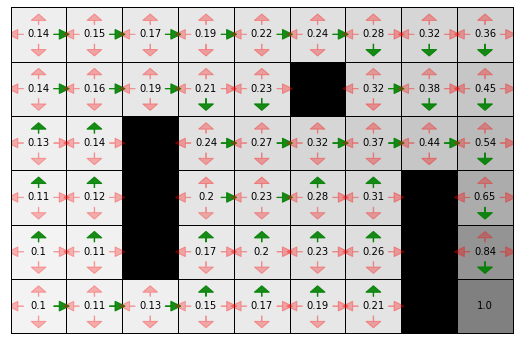

In [23]:
m.new_render()
m.render(Q_list[-1], policy_list[-1])

In [20]:
print(policy)

[1 2 0 0 0 2 1 2 0 0 0 2 1 2 0 0 0 2 1 1 2 0 0 0 1 1 2 0 0 0 2 0 2 0 0 0 1
 1 2 0 0 0 1 1 2 0 0 0 1 1 1 1 1 0]


In [21]:
print(policy_list[-1])

[2 2 2 0 0 2 2 2 0 0 0 2 2 2 0 0 0 2 2 2 2 2 0 0 2 1 2 2 0 0 2 0 2 2 0 0 1
 2 2 0 0 0 1 1 2 0 0 0 1 1 1 1 1 0]
